In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Pré-processamento e Validação
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

# Modelos
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Métricas
from sklearn.metrics import make_scorer

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [24]:
df_treinamento_raw = pd.read_csv('conjunto_de_treinamento_reg.csv')
df_teste_raw = pd.read_csv('conjunto_de_teste_reg.csv')

print("Dataframes originais carregados.")
print(f"Tamanho do treino: {df_treinamento_raw.shape}")
print(f"Tamanho do teste: {df_teste_raw.shape}")

Dataframes originais carregados.
Tamanho do treino: (4683, 21)
Tamanho do teste: (2000, 20)


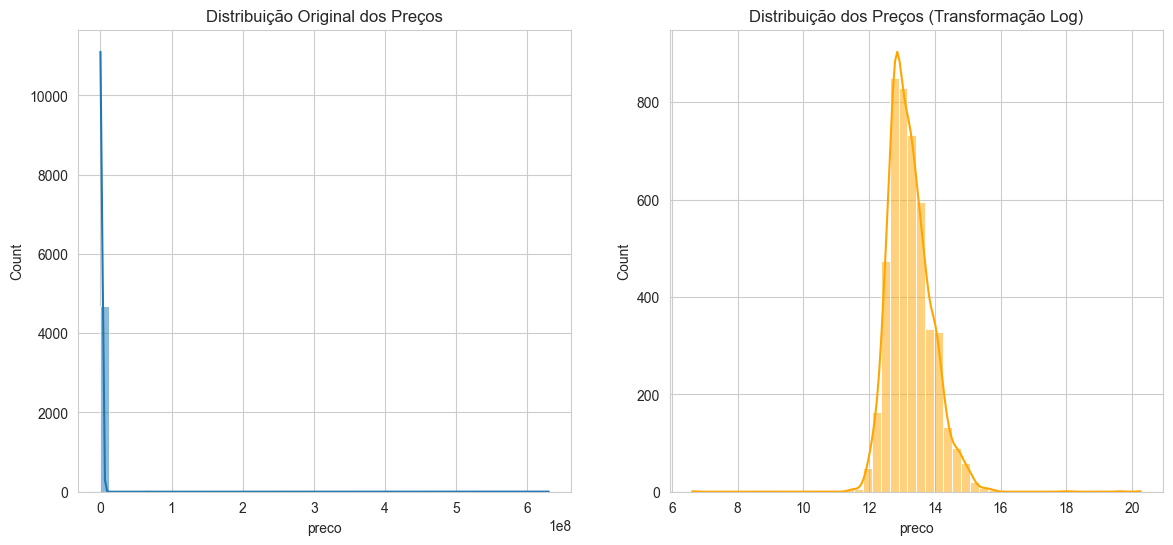

In [25]:
# Histograma do preço original vs. transformado
plt.subplot(1, 2, 1)
sns.histplot(df_treinamento_raw['preco'], kde=True, bins=50)
plt.title('Distribuição Original dos Preços')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_treinamento_raw['preco']), kde=True, bins=50, color='orange')
plt.title('Distribuição dos Preços (Transformação Log)')
plt.show()

# Definição da Métrica Customizada (RMSPE)
def rmspe(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    percentage_error = (y_true - y_pred) / y_true
    return np.sqrt(np.mean(np.square(percentage_error)))

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [26]:
def processar_features(df_train, df_test):
    # Crie cópias para não alterar os dataframes originais
    train_proc = df_train.copy()
    test_proc = df_test.copy()

    # 1. Limpeza de Dados
    median_suites = train_proc['suites'].median()
    median_area_util = train_proc['area_util'].median()
    median_area_extra = train_proc['area_extra'].median()
    for df in [train_proc, test_proc]:
        df['suites'].fillna(median_suites, inplace=True)
        df['area_util'].fillna(median_area_util, inplace=True)
        df['area_extra'].fillna(median_area_extra, inplace=True)
        df['area_util'].replace(0, median_area_util, inplace=True)

    # 2. Engenharia de Features Simples
    for df in [train_proc, test_proc]:
        df['area_total'] = df['area_util'] + df['area_extra']
        df['prop_suites_quartos'] = np.divide(df['suites'], df['quartos']).fillna(0)
        diferenciais_cols = ['churrasqueira', 'estacionamento', 'piscina', 'playground', 
                              'quadra', 's_festas', 's_jogos', 's_ginastica', 'sauna', 'vista_mar']
        df['total_diferenciais'] = df[diferenciais_cols].sum(axis=1)

    # 3. Engenharia de Features Avançada (Bairro)
    train_proc['preco_m2'] = train_proc['preco'] / train_proc['area_util']
    train_proc['preco_m2'].replace([np.inf, -np.inf], np.nan, inplace=True)
    bairro_stats = train_proc.groupby('bairro').agg(
        preco_m2_mediano_bairro=('preco_m2', 'median'),
        imoveis_por_bairro=('Id', 'count'),
        preco_std_bairro=('preco', 'std')
    ).reset_index()
    
    train_proc = pd.merge(train_proc, bairro_stats, on='bairro', how='left')
    test_proc = pd.merge(test_proc, bairro_stats, on='bairro', how='left')
    
    for col in ['preco_m2_mediano_bairro', 'imoveis_por_bairro', 'preco_std_bairro']:
        global_median = train_proc[col].median()
        train_proc[col].fillna(global_median, inplace=True)
        test_proc[col].fillna(global_median, inplace=True)
        
    return train_proc, test_proc

df_treinamento, df_teste = processar_features(df_treinamento_raw, df_teste_raw)
print("Engenharia de features concluída.")

Engenharia de features concluída.


C:\Users\PICHAU\AppData\Local\Temp\ipykernel_1476\3332926877.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['suites'].fillna(median_suites, inplace=True)
C:\Users\PICHAU\AppData\Local\Temp\ipykernel_1476\3332926877.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [ ]:
# Preparação das variáveis X, y e X_test
X = df_treinamento.drop(columns=['Id', 'preco', 'preco_m2', 'diferenciais'])
y = np.log1p(df_treinamento['preco'])
X_test = df_teste.drop(columns=['Id', 'diferenciais'])
X_test = X_test[X.columns] # Garante a mesma ordem de colunas

# Definição do Preprocessor
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features_low = ['tipo', 'tipo_vendedor']
categorical_features_high = ['bairro']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_low),
        ('cat_high', TargetEncoder(), categorical_features_high)
    ],
    remainder='drop'
)

# Definição da Estratégia de Validação Cruzada
num_bins = 10
preco_bins = pd.cut(df_treinamento_raw['preco'], bins=num_bins, labels=False)
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Variáveis X, y, X_test, preprocessor e cv_strategy prontas.")

Variáveis X, y, X_test, preprocessor e cv_strategy prontas.


In [28]:
# Dicionário para guardar os melhores parâmetros encontrados
best_params_dict = {}

def objective(trial, model_class):
    # Define os parâmetros de busca para cada modelo
    if model_class == RandomForestRegressor:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 10, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }
    elif model_class == LGBMRegressor:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        }
    elif model_class == XGBRegressor:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        }
    
    # Cria o pipeline e calcula o score
    model = model_class(**params, random_state=42, n_jobs=-1)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    score = cross_val_score(pipeline, X, y, cv=cv_strategy.split(X, preco_bins), scoring=rmspe_scorer, n_jobs=-1)
    return score.mean()

# Otimizando cada modelo
for model_name, model_class in [("RF", RandomForestRegressor), ("LGBM", LGBMRegressor), ("XGB", XGBRegressor)]:
    print(f"\nOtimizando {model_name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_class), n_trials=50) # 50 tentativas por modelo
    best_params_dict[model_name] = study.best_params
    print(f"Melhor score para {model_name}: {-study.best_value:.4f}")
    print(f"Melhores parâmetros: {study.best_params}")

[I 2025-07-19 00:05:22,493] A new study created in memory with name: no-name-63deda67-0510-4d29-b07e-14004a34ed36
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(



Otimizando RF...


[I 2025-07-19 00:05:45,999] Trial 0 finished with value: -1.4754542512595514 and parameters: {'n_estimators': 937, 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 20}. Best is trial 0 with value: -1.4754542512595514.
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
[I 2025-07-19 00:06:21,996] Trial 1 finished with value: -1.315680509265996 and parameters: {'n_estimators': 954, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: -1.4754542512595514.
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
[I 2025-07-19 00:06:40,068] Trial 2 finished with value: -1.3837020105158424 and paramete

Melhor score para RF: 1.4758
Melhores parâmetros: {'n_estimators': 927, 'max_depth': 42, 'min_samples_split': 12, 'min_samples_leaf': 20}

Otimizando LGBM...


[I 2025-07-19 00:18:18,417] Trial 0 finished with value: -1.376357279277475 and parameters: {'n_estimators': 1391, 'learning_rate': 0.1159716893992886, 'num_leaves': 67, 'reg_alpha': 0.929286699734233, 'reg_lambda': 0.000329220153948799}. Best is trial 0 with value: -1.376357279277475.
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
[I 2025-07-19 00:18:21,953] Trial 1 finished with value: -1.4710032242678508 and parameters: {'n_estimators': 256, 'learning_rate': 0.010346143587375053, 'num_leaves': 64, 'reg_alpha': 0.0002748798752750085, 'reg_lambda': 0.00012920215723839315}. Best is trial 1 with value: -1.4710032242678508.
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less 

Melhor score para LGBM: 1.6590
Melhores parâmetros: {'n_estimators': 1694, 'learning_rate': 0.17581107196408405, 'num_leaves': 89, 'reg_alpha': 1.4638272579365664e-06, 'reg_lambda': 2.8974743285458478e-08}

Otimizando XGB...


[I 2025-07-19 00:40:38,629] Trial 0 finished with value: -1.5269945283324597 and parameters: {'n_estimators': 1383, 'learning_rate': 0.033682504675578456, 'max_depth': 5, 'subsample': 0.7834869082790148, 'colsample_bytree': 0.6425031658731318}. Best is trial 0 with value: -1.5269945283324597.
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
[I 2025-07-19 00:40:44,364] Trial 1 finished with value: -1.492656638943093 and parameters: {'n_estimators': 1835, 'learning_rate': 0.030104236911886073, 'max_depth': 5, 'subsample': 0.8447716749939111, 'colsample_bytree': 0.866321270751817}. Best is trial 0 with value: -1.5269945283324597.
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is le

Melhor score para XGB: 3.1916
Melhores parâmetros: {'n_estimators': 904, 'learning_rate': 0.059032756288875866, 'max_depth': 12, 'subsample': 0.9860598553318931, 'colsample_bytree': 0.8636339577452876}


In [ ]:
# Crie instâncias dos modelos base com os melhores parâmetros encontrados
rf_final = RandomForestRegressor(**best_params_dict['RF'], random_state=42)
lgbm_final = LGBMRegressor(**best_params_dict['LGBM'], random_state=42)
xgb_final = XGBRegressor(**best_params_dict['XGB'], random_state=42)

# Defina a lista de estimadores e o modelo de Stacking
estimators = [
    ('RandomForest', rf_final),
    ('LightGBM', lgbm_final),
    ('XGBoost', xgb_final)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=cv_strategy.split(X, preco_bins)
)

# Crie o pipeline final
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacker', stacking_model)
])

# Treine o modelo final
print("\nTreinando o modelo de Stacking final... Isso pode levar alguns minutos.")
stacking_pipeline.fit(X, y)
print("Treinamento concluído.")

# Faça as predições
predictions_log = stacking_pipeline.predict(X_test)
final_predictions = np.expm1(predictions_log)
test_ids = df_teste['Id'].values

# Crie e salve o arquivo de submissão
submission_df = pd.DataFrame({'Id': test_ids, 'preco': final_predictions})
submission_df['preco'] = submission_df['preco'].clip(lower=0)
submission_df.to_csv('submission_stacking_lgbm_final.csv', index=False)

print("\nArquivo 'submission_stacking_final.csv' criado com sucesso!")
print(submission_df.head())

Processando modelo base: RF...


c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Processando modelo base: LGBM...


c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1130
[LightGBM] [Info] Number of data points in the train set: 4683, number of used features: 48
[LightGBM] [Info] Start training from score 13.242461


c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\PICHAU\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Processando modelo base: XGB...

Otimizando os pesos do ensemble...

Pesos Ótimos Encontrados: RF=0.6659, LGBM=0.0000, XGB=0.3341

Arquivo 'submission_ensemble_pesos_otimizados.csv' criado com sucesso!
   Id         preco
0   0  1.635240e+06
1   1  2.627991e+05
2   2  5.833899e+05
3   3  2.243364e+05
4   4  2.832102e+05
